In [2]:
import pandas as pd
df = pd.read_csv('C:/notebook/multiclasstextclassification/Consumer_Complaints.csv',low_memory=False)
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,01/31/2019,Vehicle loan or lease,Loan,Struggling to pay your loan,Denied request to lower payments,NaN,NaN,ALLY FINANCIAL INC.,IL,60046,NaN,NaN,Web,01/31/2019,In progress,Yes,NaN,3138185
1,01/31/2019,Vehicle loan or lease,Loan,Struggling to pay your loan,Loan balance remaining after the vehicle is re...,NaN,NaN,ALLY FINANCIAL INC.,GA,31206,Older American,NaN,Postal mail,01/31/2019,In progress,Yes,NaN,3139024
2,01/31/2019,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,NaN,NaN,"RSI Enterprises, Inc.",NM,NaN,NaN,NaN,Web,01/31/2019,Closed with explanation,Yes,NaN,3139332
3,01/31/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,ALLY FINANCIAL INC.,CA,94598,Servicemember,NaN,Web,01/31/2019,In progress,Yes,NaN,3138283
4,01/31/2019,Debt collection,I do not know,Attempts to collect debt not owed,Debt was result of identity theft,NaN,NaN,American Coradius International LLC,CA,92116,NaN,NaN,Web,01/31/2019,Closed with explanation,Yes,NaN,3138299


In [3]:
from io import StringIO
col = ['Product', 'Consumer complaint narrative']
df = df[col]

In [4]:
df.head(1)

,Product,Consumer complaint narrative
0,Vehicle loan or lease,NaN


In [5]:
df = df[pd.notnull(df['Consumer complaint narrative'])]

In [6]:
df.columns = ['Product', 'Consumer_complaint_narrative']

In [7]:
df['category_id'] = df['Product'].factorize()[0]

In [8]:
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')

In [9]:
category_to_id = dict(category_id_df.values)

In [10]:
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [11]:
df.count()

Product                         363193
Consumer_complaint_narrative    363193
category_id                     363193
dtype: int64

### Imbalanced Classes

<IPython.core.display.Javascript object>


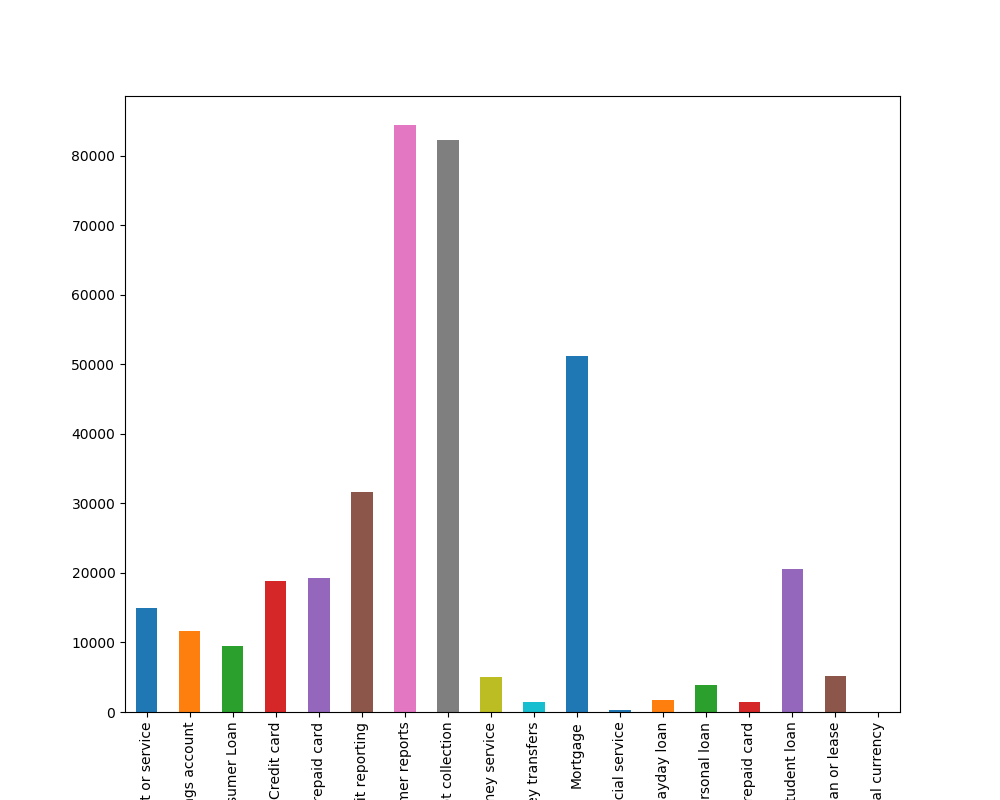

In [17]:
import matplotlib.pyplot as plt
%matplotlib notebook
fig = plt.figure(figsize=(10,8))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

##### Conventional algorithms are often biased towards the majority class, not taking the data distribution into consideration. In the worst case, minority classes are treated as outliers and ignored. For some cases, such as fraud detection or cancer prediction, we would need to carefully configure our model or artificially balance the dataset, for example by undersampling or oversampling each class.

###### bag of words model: a model where for each document, a complaint narrative in our case, the presence (and often the frequency) of words is taken into consideration, but the order in which they occur is ignored.

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=0.01,norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

In [19]:
features = tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()

In [16]:
labels = df.category_id
features.shape

(363193, 1302)

In [20]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bank account or service':
  . Most correlated unigrams:
. bank
. overdraft
  . Most correlated bigrams:
. debit card
. checking account
# 'Checking or savings account':
  . Most correlated unigrams:
. overdraft
. deposit
  . Most correlated bigrams:
. debit card
. checking account
# 'Consumer Loan':
  . Most correlated unigrams:
. vehicle
. car
  . Most correlated bigrams:
. xxxx payments
. payment xxxx
# 'Credit card':
  . Most correlated unigrams:
. citi
. card
  . Most correlated bigrams:
. card company
. credit card
# 'Credit card or prepaid card':
  . Most correlated unigrams:
. express
. card
  . Most correlated bigrams:
. card xxxx
. credit card
# 'Credit reporting':
  . Most correlated unigrams:
. equifax
. experian
  . Most correlated bigrams:
. report xxxx
. credit report
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Most correlated unigrams:
. inquiries
. equifax
  . Most correlated bigrams:
. xxxx experian
. credit report
# 'Debt c

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [37]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Debt collection']


In [38]:
df[df['Consumer_complaint_narrative'] == "This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."]

,Product,Consumer_complaint_narrative,category_id
688842,Debt collection,This company refuses to provide me verificatio...,0


In [39]:
print(clf.predict(count_vect.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"])))

['Credit reporting, credit repair services, or other personal consumer reports']


In [40]:
df[df['Consumer_complaint_narrative'] == "I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"]

,Product,Consumer_complaint_narrative,category_id
654955,Credit reporting,I am disputing the inaccurate information the ...,9
